In [1]:
using Pkg
Pkg.add("Plots")
Pkg.add("Interpolations")
Pkg.add("QuadGK")
Pkg.add("Unitful")
Pkg.add("UnitfulAstro")
Pkg.add("Random")
Pkg.add("SpecialFunctions")
Pkg.add("Roots")
Pkg.add("Trapz")
Pkg.add("PhysicalConstants")
Pkg.add("Cosmology")
Pkg.add("DataInterpolations")
Pkg.add("MeshGrid")
Pkg.add("PlotlyJS")

   Resolving package versions...
  No Changes to `~/home/triax-painting-tSZ/Project.toml`
  No Changes to `~/home/triax-painting-tSZ/Manifest.toml`
   Resolving package versions...
  No Changes to `~/home/triax-painting-tSZ/Project.toml`
  No Changes to `~/home/triax-painting-tSZ/Manifest.toml`
   Resolving package versions...
  No Changes to `~/home/triax-painting-tSZ/Project.toml`
  No Changes to `~/home/triax-painting-tSZ/Manifest.toml`
   Resolving package versions...
  No Changes to `~/home/triax-painting-tSZ/Project.toml`
  No Changes to `~/home/triax-painting-tSZ/Manifest.toml`
   Resolving package versions...
  No Changes to `~/home/triax-painting-tSZ/Project.toml`
  No Changes to `~/home/triax-painting-tSZ/Manifest.toml`
   Resolving package versions...
  No Changes to `~/home/triax-painting-tSZ/Project.toml`
  No Changes to `~/home/triax-painting-tSZ/Manifest.toml`
   Resolving package versions...
  No Changes to `~/home/triax-painting-tSZ/Project.toml`
  No Changes to `~/hom

In [1]:
using Plots 
using Interpolations
using QuadGK
using Unitful, UnitfulAstro
using Random
using SpecialFunctions
using Roots
using Trapz
using PhysicalConstants
using Cosmology
using MeshGrid
import DataInterpolations 
using LinearAlgebra
using StaticArrays
using Statistics

0.14997285514001335:5.483847312766256e-7:0.15002714522840974

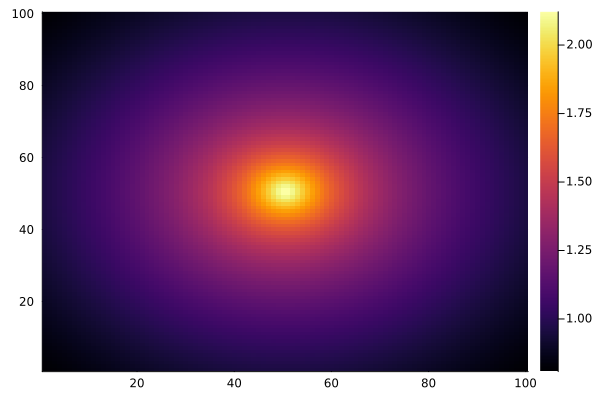

In [70]:
using Cosmology
using Unitful, UnitfulAstro
using Roots
function euler_rotation_matrix(θ, φ, ψ)
    Rzϕ = @SMatrix[
        cos(φ)  -sin(φ)   0
        sin(φ)   cos(φ)   0
           0        0     1
    ]
    Rxθ = @SMatrix[
           1        0         0
           0   cos(θ)   -sin(θ)
           0   sin(θ)    cos(θ)
    ]
    Rzψ = @SMatrix[
        cos(ψ)  -0   -sin(ψ)
        0       1   0
        sin(ψ)  0   cos(ψ)
    ]

    return Rzψ * Rxθ * Rzϕ
end

function meshgrid_radec_to_cartesian(ra, dec; ra0, dec0, z0, 
        cosmo=cosmology(), 
        RotationMatrix = nothing
        )
    Nz = length(ra)
    deg2rad = π/180
    ra_rad  = ra .* deg2rad
    dec_rad = dec .* deg2rad
    ra0_rad, dec0_rad = ra0*deg2rad, dec0*deg2rad

    # comoving distance at center
    Dc0 = ustrip(comoving_radial_dist(cosmo, z0))

    # -----------------------------
    # compute transverse physical size
    Δra_max  = maximum(abs.(ra_rad .- ra0_rad))
    Δdec_max = maximum(abs.(dec_rad .- dec0_rad))
    Δx_max = Dc0 * cos(dec0_rad) * Δra_max
    Δy_max = Dc0 * Δdec_max
    max_size = max(Δx_max, Δy_max)

    # -----------------------------
    # define LOS comoving interval around Dc0
    Dc_min = Dc0 - max_size
    Dc_max = Dc0 + max_size

    # invert D_C(z) numerically to get redshift interval
    f_inv(z) = ustrip(comoving_radial_dist(cosmo, z))
    z_min = find_zero(z -> f_inv(z) - Dc_min, z0-0.1)
    z_max = find_zero(z -> f_inv(z) - Dc_max, z0+0.1)

    # create LOS redshift grid
    z = range(z_min, z_max, length=Nz)
    print(z)
    # -----------------------------
    # convert to Cartesian
    x   = reshape([ustrip(comoving_radial_dist(cosmo, zi)) for zi in z], 1,1,:) .* cos.(reshape(dec_rad,1,:,1)) .* cos.(reshape(ra_rad,:,1,1))
    y   = reshape([ustrip(comoving_radial_dist(cosmo, zi)) for zi in z], 1,1,:) .* cos.(reshape(dec_rad,1,:,1)) .* sin.(reshape(ra_rad,:,1,1))
    zc  = reshape([ustrip(comoving_radial_dist(cosmo, zi)) for zi in z], 1,1,:) .* sin.(reshape(dec_rad,1,:,1))

    # -----------------------------
    # subtract center
    x0 = Dc0 * cos(dec0_rad) * cos(ra0_rad)
    y0 = Dc0 * cos(dec0_rad) * sin(ra0_rad)
    z0c = Dc0 * sin(dec0_rad)

    x .-= x0
    y .-= y0
    zc .-= z0c
    zc = zc .+ 0. * x
    # -----------------------------
    # apply rotation if provided
    if RotationMatrix !== nothing
        Nx, Ny, Nz_ = length(ra), length(dec), length(z)
        coords = vcat(reshape(x,1,:), reshape(y,1,:), reshape(zc,1,:))   # 3 × (Nx*Ny*Nz)
        rot_coords = RotationMatrix * coords
        x = reshape(rot_coords[1,:], Nx, Ny, Nz_)
        y = reshape(rot_coords[2,:], Nx, Ny, Nz_)
        zc = reshape(rot_coords[3,:], Nx, Ny, Nz_)
    end

    return x, y, zc, z
end

c = cosmology()

ra0, dec0, z0 = 0., 0., 0.15    # center
ra  = collect(range(-0.01, 0.01, 100))
dec = collect(range(-0.01, 0.01, 100))
R = euler_rotation_matrix(0., 0., 0.)
z = 0.15

x,y, zlos, z = meshgrid_radec_to_cartesian(ra, dec; 
        ra0 = 0., dec0 = 0.,
        z0 = z, 
        cosmo = c, 
        RotationMatrix = R)

ϵ₁ = 0.85
ϵ₂ = 0.

ζ = @. 1/sqrt(x^2/(1-ϵ₁)^2 + y^2 + zlos^2/(1-ϵ₂)^2)
heatmap(log10.(abs.(ζ[:,:,50])))






In [10]:
z = range(0, 1, length = 100)
comoving_radial_dist(c, z)

LoadError: MethodError: no method matching Z(::Cosmology.FlatLCDM{Float64}, ::Vector{Float64}, ::Nothing)
The function `Z` exists, but no method is defined for this combination of argument types.

[0mClosest candidates are:
[0m  Z(::Cosmology.AbstractCosmology, [91m::Real[39m, ::Nothing; kws...)
[0m[90m   @[39m [35mCosmology[39m [90m~/.julia/packages/Cosmology/DrQed/src/[39m[90m[4mCosmology.jl:287[24m[39m
[0m  Z(::Cosmology.AbstractCosmology, [91m::Real[39m, [91m::Real[39m; kws...)
[0m[90m   @[39m [35mCosmology[39m [90m~/.julia/packages/Cosmology/DrQed/src/[39m[90m[4mCosmology.jl:289[24m[39m


In [2]:
import PhysicalConstants.CODATA2018 as constants
const M_sun = 1.98847e30u"kg"
const T_cmb =  2.725 * u"K"
const P_e_factor = constants.σ_e / (constants.m_e * constants.c_0^2)

8.125531675591423e-16 s^2 kg^-1

In [77]:
abstract type AbstractProfileWorkspace{T} end
abstract type AbstractProfile{T} end
abstract type AbstractGNFW{T} <: AbstractProfile{T} end
abstract type AbstractInterpolatorProfile{T} <: AbstractProfile{T} end


struct LogInterpolatorProfile{T, P <: AbstractProfile{T}, I1, C} <: AbstractInterpolatorProfile{T}
    model::P
    itp::I1
    cosmo::C
end

function LogInterpolatorProfile(model::AbstractProfile, itp)
    return LogInterpolatorProfile(model, itp, model.cosmo)  # use wrapped cosmology
end


struct Battaglia16ThermalSZProfile{T,C} <: AbstractGNFW{T}
    f_b::T
    cosmo::C
end

function Battaglia16ThermalSZProfile(; Omega_c::T=0.2589, Omega_b::T=0.0486, h::T=0.6774) where {T <: Real}
    OmegaM=Omega_b+Omega_c
    f_b = Omega_b / OmegaM
    cosmo = get_cosmology(T, h=h, OmegaM=OmegaM)
    return Battaglia16ThermalSZProfile(f_b, cosmo)
end

function get_params(::AbstractGNFW{T}, M_200, z) where T
	z₁ = z + 1
	m = M_200 / (1e14M_sun)
	P₀ = 18.1 * m^0.154 * z₁^-0.758
	xc = 0.497 * m^-0.00865 * z₁^0.731
	β = 4.35 * m^0.0393 * z₁^0.415
	α = 1
    γ = -0.3
    β = γ - α * β  # Sigurd's conversion from Battaglia to standard NFW
    return (xc=T(xc), α=T(α), β=T(β), γ=T(γ), P₀=T(P₀))
end

function get_cosmology(::Type{T}; h=0.69,
                   Neff=3.04,
                   OmegaK=0.0,
                   OmegaM=0.29,
                   OmegaR=nothing,
                   Tcmb=2.7255,
                   w0=-1,
                   wa=0) where T

    if OmegaR === nothing
        OmegaG = 4.48131e-7*Tcmb^4/h^2
        OmegaN = Neff*OmegaG*(7/8)*(4/11)^(4/3)
        OmegaR = OmegaG + OmegaN
    end

    OmegaL = 1 - OmegaK - OmegaM - OmegaR

    if !(w0 == -1 && wa == 0)
        return Cosmology.WCDM{T}(h, OmegaK, OmegaL, OmegaM, OmegaR, w0, wa)
    end

    if OmegaK < 0
        return Cosmology.ClosedLCDM{T}(h, OmegaK, OmegaL, OmegaM, OmegaR)
    elseif OmegaK > 0
        return Cosmology.OpenLCDM{T}(h, OmegaK, OmegaL, OmegaM, OmegaR)
    else
        return Cosmology.FlatLCDM{T}(h, OmegaL, OmegaM, OmegaR)
    end
end
get_cosmology(; h=0.69, Neff=3.04, OmegaK=0.0, OmegaM=0.29, OmegaR=nothing, Tcmb=2.7255, 
    w0=-1, wa=0) = get_cosmology(Float32; h=h, Neff=Neff, OmegaK=OmegaK, 
        OmegaM=OmegaM, OmegaR=OmegaR, Tcmb=Tcmb, w0=w0, wa=wa)


function ρ_crit(model, z)
    H_z = H(model.cosmo, z)
    return uconvert(u"kg/m^3", 3H_z^2 / (8π * constants.G))
end

function R_Δ(model, M_Δ, z, Δ=200)
    return ∛(M_Δ / (4π/3 * Δ * ρ_crit(model, z)))
end

function angular_size(model::AbstractProfile{T}, physical_size, z) where T
    d_A = angular_diameter_dist(model.cosmo, z)

    # convert both to the same units and strip units for atan
    phys_siz_unitless = @. T.(ustrip.(uconvert.(unit(d_A), physical_size)))
    d_A_unitless = T(ustrip(d_A))
    return atan.(phys_siz_unitless, d_A_unitless)
end

function build_z2r_interpolator(min_z::T, max_z::T,
    cosmo::Cosmology.AbstractCosmology; n_bins=2000) where T

    zrange = LinRange(min_z, max_z, n_bins)
    rrange = zero(zrange)
    for i in 1:n_bins
        rrange[i] = ustrip(T, u"Mpc",
            Cosmology.comoving_radial_dist(u"Mpc", cosmo, zrange[i]))
    end
    z2r = DataInterpolations.LinearInterpolation(rrange, zrange);
    return z2r
end

function euler_rotation_matrix(θ, φ, ψ)
    Rzϕ = @SMatrix[
        cos(φ)  -sin(φ)   0
        sin(φ)   cos(φ)   0
           0        0     1
    ]
    Rxθ = @SMatrix[
           1        0         0
           0   cos(θ)   -sin(θ)
           0   sin(θ)    cos(θ)
    ]
    Rzψ = @SMatrix[
        cos(ψ)  -sin(ψ)   0
        sin(ψ)   cos(ψ)   0
           0        0     1
    ]

    return Rzψ * Rxθ * Rzϕ
end

function generalized_nfw(x, xc, α, β, γ)
    x̄ = x ./ xc
    return x̄.^γ .* (1 .+ x̄.^α).^((β .- γ) ./ α)
end

function _generalized_scaled_nfw(x̄, α, β, γ)
    return x̄.^γ .* (1 .+ x̄.^α).^((β .- γ) ./ α)
end

function _nfw_profile_los_quadrature(x, xc, α, β, γ; zmax=1e5, rtol=eps(), order=9)
    x² = x.^2
    scale = 1e9
    integral, err = @. quadgk(y -> scale * generalized_nfw(sqrt.(y^2 .+ x²), xc, α, β, γ),
                      0.0, zmax, rtol=rtol, order=order)
    return 2integral / scale
end

function radial_profile_arcmin(x, y, data, r_bins, DA)

    factor = 180/π * 60
    x′ = x ./ DA .* factor
    y′ = y ./ DA .* factor
    r = sqrt.(x′.^2 .+ y′.^2)
    r_flat = vec(r)
    d_flat = vec(data)
    
    @assert length(r_bins) > 1 "Need at least two bins to infer Δr"
    Δr = r_bins[2] - r_bins[1]
    profile = similar(r_bins, Float64)
    for (i, R) in enumerate(r_bins)
        inds = findall(abs.(r_flat .- R) .< Δr/2)
        if isempty(inds)
            profile[i] = NaN
        else
            profile[i] = mean(d_flat[inds])
        end
    end

    return profile
end

#functions from XGpaint 

function dimensionless_P_profile_los(model::Battaglia16ThermalSZProfile{T}, r, M_200, z) where T
    par = get_params(model, M_200, z)
    R_200 = R_Δ(model, M_200, z, 200)
    x = r / angular_size(model, R_200, z)
    return par.P₀ * _nfw_profile_los_quadrature(x, par.xc, par.α, par.β, par.γ)
end

"""Line-of-sight integrated electron pressure"""
P_e_los(model, r, M_200c, z) = 0.5176 * P_th_los(model, r, M_200c, z)

"""Line-of-sight integrated thermal pressure"""
P_th_los(model, r, M_200c, z) = constants.G * M_200c * 200 * ρ_crit(model, z) * 
    model.f_b / 2 * dimensionless_P_profile_los(model, r, M_200c, z)

"""
    compton_y(model, r, M_200c, z)

Calculate the Compton y parameter for a given model at a given radius, mass, and redshift.
Mass needs to have units!
"""
function compton_y(model::Battaglia16ThermalSZProfile, r, M_200c, z)
    return P_e_los(model, r, M_200c, z) * P_e_factor .+ 0   # +0 to strip units
end


compton_y

# Equations from Kim et al 2025
Ellipsodial radius:
$$
\zeta^2 = \sqrt{\frac{\hat{x}^2_1}{q_1^2} + \frac{\hat{x}^2_2}{q_2^2} + \hat{x}^3_2}
$$
Prolate if $q_1 = q_2 \leq 1$ and oblate if $q_1 \leq q_2 = 1$. 
#### Euler angles 
$(x^1_{\mathrm{int}}, x^2_{\mathrm{int}}, x^3_{\mathrm{int}})\rightarrow (x^1_{\mathrm{obs}}, x^2_{\mathrm{obs}}, x^3_{\mathrm{obs}})$. There are three angles:

* $\theta$: Angle between $x^3_{\mathrm{int}}$ and $x^3_{\mathrm{obs}}$ aligned with the ellipse mayor-axis.
* $\varphi$ Angle between $x^1_{\mathrm{int}}$ and the line of nodes.
* $\phi$ Angle between $x^1_{\mathrm{obs}}$ and the line of nodes.

The **line of nodes** is the interception of the $x^{1}_{\mathrm{int}}-x^{2}_{\mathrm{int}}$ and $x^{2}_{\mathrm{int}}-x^{1}_{\mathrm{obs}}$ planes. The ellepticity $\epsilon$ of the projected profile becomes $\epsilon = 1 - q_p$, where $q_p$:
$$
q_p = \sqrt{\frac{j + l - \sqrt{(j - l)^2 + 4k^2}}{j + l + \sqrt{(j - l)^2 + 4k^2}}}
$$

$$
\begin{align}
j &= \frac{1}{2}\left[\frac{1}{q^2_1 + q^2_2}\right] - \frac{\sin{\theta}^2\cos{\psi}^2(q^2_1 + q^2_2 - 2)}{q^2_1 q^2_2} \\& - \left( \frac{1}{q_1^2}- \frac{1}{q_2^2}\right)(\cos{2\varphi}(\cos^2{\theta}\cos{\phi}^2 - \sin^2{\psi}) - \cos{\theta}\sin{2\varphi}\sin{2\psi})
\end{align}
$$
$$
\begin{align}
k &= \frac{1}{4 q_1^2 q_2^2}\Big[2\cos{\theta}(q_1^2 - q_2^2)\cos{2\phi}\cos{2\varphi} + \\&\Big(\sin{\theta}^2(q_1^2 + q_2^2 - 2) + (1 + \cos{\theta}^2)(q_1^2 - q_2^2)\cos{2\varphi} \Big)\sin{2\psi}\Big]
\end{align}
$$
$$
\begin{align}
l &= \frac{1}{2}\Big[\left(\frac{1}{q_1^2} + \frac{1}{q_2^2}\right) - \frac{\sin{\theta}^2\sin{\phi}^2(q_1^2 + q_2^2 - 2)}{q_1^2 q_2^2} - \\ & \left(\frac{1}{q_1^2} - \frac{1}{q_2^2}\right)\Big(\cos{2\varphi}(\cos{\theta}^2 \sin{\phi}^2 - \cos{\psi}^2) + \cos{\theta}\sin{2\varphi}\sin{2\phi}\Big)\Big]
\end{align}
$$

The orientation angle in the plane of the sky is
$$
\theta_{\epsilon} = \tan^{-1}{\left[\frac{l - j + \sqrt{(j - l )^2 + 4k^2}}{2k}\right]}
$$
And the elongation parameter
$$
\epsilon_{\parallel} = \sqrt{\frac{q_p}{q_1q_2}}f^{-3/4}
$$
$$
f = \left[\sin{\theta}^2\left(\frac{\sin{\varphi}^2}{q_1^2}+\frac{\cos{\varphi}^2}{q_2^2}\right) + \cos{\theta}^2\right]
$$
the semimajor axis of the projected ellipse is 
$$
l_p = \frac{l_s}{\epsilon_{\parallel}\sqrt{f}}
$$
and the projected lenght scales $l_s$ and $l_{\mathrm{los}}$ are related by
$$
l_{\mathrm{los}} = l_s/\sqrt{f}
$$
Finally the elliptical radius on the plane of the sky becomes
$$
\xi^2 = \left(x^{2}_1 + \frac{x^2_2}{q_p^2}\right)\left(\frac{l_s}{l_p}\right)^2
$$
The measured 2-D projected profiles is given by
$$
F_{2D}(x_{\xi},l_p |p) = 2l_p\epsilon_{\parallel}\int_{x_{\xi}}F_{\mathrm{3D}}(x_{\zeta}, l_s| p)\frac{x_{\xi}}{\sqrt{x_{\zeta}^2 - x_{\xi}^2}}dx_{\zeta}
$$
Where $x_{\zeta} = \zeta/l_s$ and $x_{\xi} = \xi/l_p$. $l_s$ is obtained by eigvalues of shape matrix
$$
T = \text{diag}{[1, q_1, q_2]}
$$

$0 < q_1 \leq q_2 \leq 1 \rightarrow 0 < \epsilon_2 \leq \epsilon_1 < 1 $

In [94]:
function δαz2gnom(cosmo::Cosmology.AbstractCosmology, z2r::DataInterpolations.LinearInterpolation,
    δ, α, z; δ₀ = 0., α₀ = 0., ΔZ = 5e-6, NZ::Int = 500, match_z = true)
    
    Dₐ = angular_diameter_dist(cosmo,z)
    
    C̃ = @.cos(δ₀)*cos(δ)*cos(α - α₀) + sin(δ)*sin(δ₀)
    X̃ = @. Dₐ*(cos(δ)*sin(α - α₀))/C̃
    Ỹ = @. Dₐ*(sin(δ₀)*cos(δ)*cos(α - α₀) - cos(δ₀)*sin(δ))/C̃
  
    if match_z == false
        χ₀ = z2r(z)
        χ₁, χ₂ = z2r(z - ΔZ), z2r(z + ΔZ)
        Z̃ = collect(range(χ₁ -  χ₀, χ₂ - χ₀, length=length(δ)))u"Mpc"
    else
        vmin, vmax = (minimum(X̃) + minimum(Ỹ))/2 , (maximum(X̃) + maximum(Ỹ))/2
        Z̃ = collect(range(vmin, vmax, length = length(δ)))
    end
    X̃ = uconvert.(u"m", X̃)
    Ỹ = uconvert.(u"m", Ỹ)
    Z̃ = uconvert.(u"m", Z̃)
    return X̃, Ỹ, Z̃
end



function get_coords(δ, α, z, δ₀, α₀, 
        cosmo::Cosmology.AbstractCosmology; 
        θ = 0, φ = 0, ψ = 0, ϵ₁ = 0, ϵ₂ = 0, ΔZ = 1e-6, 
        z2r::Union{DataInterpolations.LinearInterpolation, Nothing} = nothing, full = false)
    
    q₁, q₂ = 1 - ϵ₁, 1 - ϵ₂
    a, b, c = 1.0, q₁, q₂
    R = euler_rotation_matrix(θ, φ, ψ)
    T = Diagonal([1/a^2, 1/b^2, 1/c^2])
    T_rot = R*T*transpose(R)
    T_proj = T_rot[1:2, 1:2]
    λ = sort(eigvals(T_proj))
    
    lₛ = 1 / sqrt(λ[1])
    lₘ = 1 / sqrt(λ[2])
    qₚ = lₘ / lₛ
    
    cθ, cφ, cψ, = cos(θ), cos(φ), cos(ψ)
    c2θ, c2φ, c2ψ, = cos(2*θ), cos(2*φ), cos(2*ψ)
    sθ, sφ, sψ = sin(θ), sin(φ), sin(ψ)
    s2θ, s2φ, s2ψ = sin(2*θ), sin(2*φ), sin(2*ψ)

    j = 1/2*(1/q₁^2 + 1/q₂^2) - ((sθ^2*cψ^2)*(q₁^2 + q₂^2 - 2))/(q₁^2*q₂^2) + (1/q₁^2 - 1/q₂^2)*(c2φ*(cθ^2*cψ^2 - sψ^2) - cθ*s2φ*s2ψ)
    k = 1/(4*q₁^2*q₂^2)*(2*cθ*(q₁^2 - q₂^2)*c2φ*c2ψ + (sθ^2 * (q₁^2 + q₂^2 -2 ) + (1+cθ^2)*(q₁^2 - q₂^2)*c2φ)*s2ψ)
    l = 1/2*(1/q₁^2 + 1/q₂^2) - ((sθ^2*sψ^2)*(q₁^2 + q₂^2 - 2))/(q₁^2*q₂^2) + (1/q₁^2 - 1/q₂^2)*(c2φ*(cθ^2*sψ^2 - cψ^2) - cθ*s2φ*s2ψ)
        
    l = clamp(l, 1, Inf)
    k = clamp(k, 1, Inf)
    j = clamp(j, 1, Inf)
        
    if z2r === nothing
        z2r = build_z2r_interpolator(1e-10, 5., cosmo)
    end
    
    x₁,x₂,x₃ = δαz2gnom(cosmo, z2r, δ, α, z; δ₀ =  δ₀, α₀ = α₀, ΔZ = ΔZ)
    x⃗₁, x⃗₂, x⃗₃ = vec(x₁), vec(x₂), vec(x₃)
    r⃗ = SMatrix{3,Int(length(x⃗₁))}([x⃗₁'; x⃗₂'; x⃗₃';]...)
    r⃗′ = R*r⃗
    x₁′ = r⃗′[1, :]
    x₂′ = r⃗′[2, :]
    x₃′ = r⃗′[3, :]
    
    X₁,X₂,X₃ = meshgrid(x₁′, x₂′, x₃′)
    
    ζ = @. sqrt((X₁/q₁)^2 + (X₂/q₂)^2 + X₃^2)
    if full == true
        q_p = sqrt( (j + l - sqrt((j - l)^2 + 4*k^2)) / 
            (j + l + sqrt((j - l)^2 + 4*k^2)))
        
        θϵ = atan((l - j + sqrt((j - l)^2 + 4*k^2))/(2*k))
        f = sθ^2 * ((sφ/q₁)^2 + (cφ/q₂)^2) + cθ^2
        ϵ_proj = sqrt(qₚ / (q₁ * q₂)) * f^(-3/4)
        lₚ = lₛ/(ϵ_proj * sqrt(f))
        l_los = lₛ/sqrt(f)
        X̃₁, X̃₂ = meshgrid(x₁′, x₂′)
        ξ = @. sqrt(X̃₁^2 + (X̃₂^2 / qₚ^2)*(lₛ/lₚ)^2)
    end
    if full == true
        return ζ, ξ, qₚ, θϵ, ϵ_proj, lₛ, lₚ, l_los, x₁′, x₂′, x₃′
    else
        return ζ
    end
end

function generalized_nfw(x, xc, α, β, γ)
    x̄ = x / xc
    return x̄^γ * (1 + x̄^α)^((β - γ) / α)
end


function ycompton(model::Battaglia16ThermalSZProfile{T}, δ, α, δ₀, α₀, M, z; θ_physical = true, 
        Zlos::Any = nothing, return_3D = false, full = false, θ = 0, φ = 0, ψ = 0, ϵ₁ = 0, ϵ₂ = 0, 
        z2r::Union{DataInterpolations.LinearInterpolation, Nothing} = nothing, 
        match_z = true, Δz = 1e-3) where T
    
    ζ, ξ, qₚ, θϵ, ϵ_proj, lₛ, lₚ, l_los, x, y, zlos  = get_coords(δ, α, z, δ₀, α₀,cosmo; θ = θ, φ = φ, ψ = ψ, 
                                                                z2r = z2r, ϵ₁ = ϵ₁, ϵ₂ = ϵ₂, full = true, 
                                                                ΔZ = Δz); 
    R_200 = R_Δ(model, M, z, 200)
    factor = constants.G * M * 200 * ρ_crit(model, z) * model.f_b / (2*R_200)* 0.5176
    par = get_params(model, M, z)
    xζ, xξ = ustrip(ζ./(lₛ*R_200)), ustrip(ξ./(lₚ*R_200))
    
    P₀, xc, α, β, γ = par.P₀, par.xc, par.α, par.β, par.γ 
    if return_3D == false
        scale = 1e9
        x² = xξ.^2
        zmax=1e10
        rtol=eps()
        order=9
        F₂D = [ quadgk(
                    y -> scale * generalized_nfw( sqrt(y^2 + xi), xc, α, β, γ ),
                    0.0, zmax;
                    rtol = rtol,
                    order = order
                )[1]
                for xi in x²
              ]
        if full == true
            return x, y, zlos, 2*lₚ*ϵ_proj*F₂D/scale
        end
            return P₀*2*lₚ*ϵ_proj*F₂D/scale
    end
    F₃D = @. P₀ * ((xζ/xc)^γ) * (1  + (xζ/xc)^α)^((β - γ) / α)
    return F₃D
end


function profile_grid(model::AbstractGNFW{T}; Nr = 128, NlogM = 128, Nz = 128, zmin = 1e-3, zmax = 5.,
    logMmin = 11., logMmax = 16., minR = -10, maxR = 10., Nϵ₁ = 128, Nϵ₂ = 128, Nrot = 128)where T
    
    Rs = LinRange(minR, maxR, length = Nr)
    logMs = LinRange(logMmin, logMmax, length = NlogM)
    redshifts = LinRange(z_min, z_max, N_z)
    ϵ₁ = LinRange(0.01, 0.99, Nϵ₁)
    ϵ₂ = LinRange(0.01, 0.99, Nϵ₂)
    ϕs = LinRange(0, 2π, Nrot)
    θs = LinRange(0, 2π, Nrot)
    ψs = LinRange(0, 2π, Nrot)
    return profile_grid(model, Rs, logMs, redshifts, ϵ₁, ϵ₂, ϕs, θs, ψs)
    
end

function profile_grid(model::AbstractGNFW{T}, Rs, logMs, redshifts, ϵ₁, ϵ₂, ϕs, θs, ψs) where T

    Nr, Nz, NlogM = length(Rs), length(redshifts), length(logMs)
    Nϵ₁, Nϵ₂, Nrot = length(ϵ₁), length(ϵ₂), length(ϕs)
    
    A = zeros(T, (Nr, Nr, Nz, NlogM, Nϵ, Nϵ, Nrot, Nrot, Nrot))
    z2r_interpolator = build_z2r_interpolator(1e-5, 5., model.cosmo);
    Threads.@threads for iz in 1:Nz
      z_val = redshifts[iz]

      for iM in 1:NM
        M_val = logMs[iM]

        for ie1 in 1:Nϵ₁, ie2 in 1:Nϵ₂
          eps1 = ϵ₁[ie1]
          eps2 = ϵ₂[ie2]

          for iϕ in 1:Nϕ, iθ in 1:Nθ, iψ in 1:Nψ
            φ_val = ϕs[iϕ]
            θ_val = θs[iθ]
            ψ_val = ψs[iψ]

            block = ycompton(model, Rs, Rs, 0, 0, M_val, z_val;
                             ϵ₁ =  eps1, ϵ₂ = eps2, φ = φ_val, 
                             θ = θ_val, ψ = ψ_val,
                             z2r = z2r_interpolato)
                    
            @inbounds A[:, :, iz, iM, ie1, ie2,iθ, iψ, iϕ] = block
          end
        end

      end
    end

    return Rs, redshifts, logMs, ϵ₁, ϵ₂, ϕs, θs, ψs, A
end

function build_interpolator(model::AbstractProfile; cache_file::String="", 
                            Nr=256, pad=256, overwrite=true, verbose=true)

    if overwrite || (isfile(cache_file) == false)
        verbose && print("Building new interpolator from model.\n")
        rs, z, logM, ϵ₁, ϵ₂, ϕ, θ, ψ, prof_y  = profile_grid(model; Nr = Nr)
        if length(cache_file) > 0
            verbose && print("Saving new interpolator to $(cache_file).\n")
            save(cache_file, 
                Dict("R"=>rs, "z"=>z, "logM"=>logM, 
                     "ϵ₁"=>ϵ₁, "ϵ₂"=>ϵ₂, "ϕ"=>ϕ, "θ"=>θ, "ψ"=>ψ,
                     "prof_y"=>prof_y ))

        end
    else
        print("Found cached Battaglia profile model. Loading from disk.\n")
        model_grid = load(cache_file)
        prof_logθs, prof_redshift, prof_logMs, prof_y = model_grid["prof_logθs"], 
            model_grid["prof_redshift"], model_grid["prof_logMs"], model_grid["prof_y"]
    end

    itp = Interpolations.interpolate(log.(prof_y), BSpline(Cubic(Line(OnGrid()))))
    interp_model = scale(itp, rs, z, logM, ϵ₁, ϵ₂, ϕ, θ, ψ)
    return LogInterpolatorProfile(model, interp_model)
end


build_interpolator (generic function with 1 method)

In [49]:
include("TriaxSZ.jl")

z = 0.15
cosmo = cosmology()
z2r_interpolator = build_z2r_interpolator(1e-5, 5., cosmo)
M = 1e14M_sun
model = Battaglia16ThermalSZProfile();
δ = collect(range(-5/60,5/60, length = 100))
α = collect(range(-5/60,5/60, length = 100))
δ₀ = 0.
α₀ = 0.

0.0

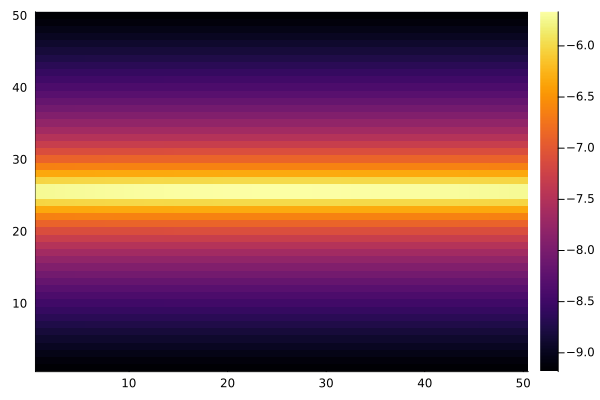

In [58]:
δ = collect(range(-0.5,0.5, length = 50))
α = collect(range(-0.5,0.5, length = 50))
δ₀ = 0.
α₀ = 0.

x,y, zlos, Y = ycompton(model, δ, α, δ₀, α₀, M, z; return_3D=false, full = true, ϵ₁ = 0.45, ϵ₂=0., 
    θ = deg2rad(90), ψ = deg2rad(0.), φ = deg2rad(0.));

heatmap(log10.(Y))

In [25]:
Nx = 5; Ny = 5; Nz = 5
x = range(-1, 1, Nx)
y = range(-1, 1, Ny)
z = range(-1, 1, Nz)

X = [x[i] for i in 1:Nx, j in 1:Ny, k in 1:Nz]
Y = [y[j] for i in 1:Nx, j in 1:Ny, k in 1:Nz]
Z = [z[k] for i in 1:Nx, j in 1:Ny, k in 1:Nz]

Xproj = X[:, :, 1]
Yproj = Y[:, :, 1]

Yproj

5×5 Matrix{Float64}:
 -1.0  -0.5  0.0  0.5  1.0
 -1.0  -0.5  0.0  0.5  1.0
 -1.0  -0.5  0.0  0.5  1.0
 -1.0  -0.5  0.0  0.5  1.0
 -1.0  -0.5  0.0  0.5  1.0

In [51]:
θ.*60

10-element LinRange{Float64, Int64}:
 0.0, 0.666667, 1.33333, 2.0, 2.66667, 3.33333, 4.0, 4.66667, 5.33333, 6.0